# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-07-12 14:16:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... 

connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip.4’

    [                                   <=> ] 29,224,203  3.92MB/s   in 7.7s   

2023-07-12 14:16:27 (3.63 MB/s) - ‘NewsAggregatorDataset.zip.4’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of NewsAggregatorDataset.zip or
        NewsAggregatorDataset.zip.zip, and cannot find NewsAggregatorDataset.zip.ZIP, period.


In [2]:
!wc -l ./newsCorpora.csv

wc: ./newsCorpora.csv: No such file or directory


In [3]:
!head -10 ./newsCorpora.csv

head: cannot open ‘./newsCorpora.csv’ for reading: No such file or directory


In [6]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
CATEGORY
b    4501
e    4235
t    1220
m     728
Name: count, dtype: int64
【検証データ】
CATEGORY
b    563
e    529
t    153
m     91
Name: count, dtype: int64
【評価データ】
CATEGORY
b    563
e    530
t    152
m     91
Name: count, dtype: int64


In [12]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [13]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [14]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [15]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.LongTensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.LongTensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.LongTensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [16]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

## 71. 単層ニューラルネットワークによる予測
***
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$
\hat{y}_1=softmax(x_1W),\\\hat{Y}=softmax(X_{[1:4]}W)
$$

ただし，$softmax$はソフトマックス関数，$X_{[1:4]}∈\mathbb{R}^{4×d}$は特徴ベクトル$x_1$,$x_2$,$x_3$,$x_4$を縦に並べた行列である．

$$
X_{[1:4]}=\begin{pmatrix}x_1\\x_2\\x_3\\x_4\end{pmatrix}
$$

行列$W \in \mathbb{R}^{d \times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$\hat{\boldsymbol y_1} \in \mathbb{R}^L$は未学習の行列$W$で事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである．
同様に，$\hat{Y} \in \mathbb{R}^{n \times L}$は，学習データの事例$x_1, x_2, x_3, x_4$について，各カテゴリに属する確率を行列として表現している．



In [17]:
from torch import nn
torch.manual_seed(0)

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)  # Linear(入力次元数, 出力次元数)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [18]:
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model.forward(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.4273, 0.0958, 0.2492, 0.2277]], grad_fn=<SoftmaxBackward0>)


In [19]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.4273, 0.0958, 0.2492, 0.2277],
        [0.2445, 0.2431, 0.0197, 0.4927],
        [0.7853, 0.1132, 0.0291, 0.0724],
        [0.5279, 0.2319, 0.0873, 0.1529]], grad_fn=<SoftmaxBackward0>)


## 72. 損失と勾配の計算
***
学習データの事例$x_1$と事例集合$x_1$,$x_2$,$x_3$,$x_4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．

$$l_i=−log[事例x_iがy_iに分類される確率]$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
l_1 = criterion(model.forward(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.8503
勾配:
tensor([[-0.0479, -0.0032, -0.0039,  ..., -0.0430, -0.0248,  0.0497],
        [ 0.0080,  0.0005,  0.0007,  ...,  0.0072,  0.0041, -0.0083],
        [ 0.0208,  0.0014,  0.0017,  ...,  0.0187,  0.0108, -0.0216],
        [ 0.0190,  0.0013,  0.0016,  ...,  0.0171,  0.0099, -0.0198]])


In [22]:
l = criterion(model.forward(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.8321
勾配:
tensor([[-0.0063,  0.0042, -0.0139,  ..., -0.0272,  0.0201,  0.0263],
        [-0.0047, -0.0025,  0.0195,  ...,  0.0196,  0.0160,  0.0009],
        [ 0.0184, -0.0110, -0.0148,  ...,  0.0070, -0.0055, -0.0001],
        [-0.0074,  0.0092,  0.0092,  ...,  0.0006, -0.0306, -0.0272]])


## 73. 確率的勾配降下法による学習
***
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列$W$を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [23]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    if isinstance(idx, torch.Tensor):
      idx = idx.tolist()
    return [self.X[idx], self.y[idx]]

In [24]:
from torch.utils.data import DataLoader

dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)
dataset_test = CreateDataset(X_test, y_test)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

print(len(dataset_train))
print(next(iter(dataloader_train)))

10684
[tensor([[ 0.0136,  0.0534, -0.1031,  0.1454, -0.0961, -0.0860, -0.0045, -0.0859,
          0.1795,  0.1341,  0.0478,  0.0338,  0.1164,  0.0237, -0.0956,  0.1646,
          0.0115,  0.1988,  0.1202, -0.1228,  0.1118,  0.2037,  0.0202,  0.0987,
          0.0326,  0.0799,  0.0320, -0.0165, -0.0142,  0.1012, -0.0157, -0.0777,
          0.0081, -0.1617, -0.0749, -0.0753, -0.0570,  0.0196,  0.0740,  0.0639,
          0.1031, -0.0536,  0.1189,  0.0629,  0.0117, -0.0271, -0.0884,  0.0239,
         -0.0851,  0.1876,  0.0524, -0.0073,  0.0603,  0.1888,  0.0275,  0.0389,
         -0.0456, -0.0035,  0.1208, -0.2223, -0.1039,  0.0945, -0.1498, -0.0628,
          0.0249,  0.0704,  0.0340, -0.0120,  0.1417,  0.0983, -0.0943, -0.1523,
          0.1348,  0.0499, -0.1600, -0.0050,  0.0645,  0.1652,  0.1330, -0.0375,
          0.0249, -0.1174, -0.0859,  0.1272,  0.0295, -0.0252, -0.1507,  0.1176,
         -0.0111, -0.0694,  0.0380, -0.0569, -0.0345,  0.0492, -0.1675, -0.1449,
          0.1221,  0.

In [25]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model.forward(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4671, loss_valid: 0.3540
epoch: 2, loss_train: 0.3113, loss_valid: 0.3261
epoch: 3, loss_train: 0.2825, loss_valid: 0.3112
epoch: 4, loss_train: 0.2666, loss_valid: 0.3101
epoch: 5, loss_train: 0.2564, loss_valid: 0.3055
epoch: 6, loss_train: 0.2485, loss_valid: 0.3056
epoch: 7, loss_train: 0.2443, loss_valid: 0.3055
epoch: 8, loss_train: 0.2398, loss_valid: 0.3057
epoch: 9, loss_train: 0.2359, loss_valid: 0.3174
epoch: 10, loss_train: 0.2333, loss_valid: 0.3037


## 74. 正解率の計測
***
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [26]:
def calculate_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    outputs = model(X)
    pred = torch.argmax(outputs, dim=-1)

  return (pred == y).sum().item() / len(y)

In [27]:
# 正解率の確認
acc_train = calculate_accuracy(model, X_train, y_train)
acc_test = calculate_accuracy(model, X_test, y_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.923
正解率（評価データ）：0.905


## 75. 損失と正解率のプロット
***
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [28]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total

In [29]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3303, accuracy_train: 0.8855, loss_valid: 0.3657, accuracy_valid: 0.8645
epoch: 2, loss_train: 0.2861, accuracy_train: 0.9042, loss_valid: 0.3305, accuracy_valid: 0.8825
epoch: 3, loss_train: 0.2700, accuracy_train: 0.9079, loss_valid: 0.3250, accuracy_valid: 0.8825
epoch: 4, loss_train: 0.2542, accuracy_train: 0.9130, loss_valid: 0.3157, accuracy_valid: 0.8952
epoch: 5, loss_train: 0.2525, accuracy_train: 0.9149, loss_valid: 0.3158, accuracy_valid: 0.8975
epoch: 6, loss_train: 0.2399, accuracy_train: 0.9194, loss_valid: 0.3088, accuracy_valid: 0.8885
epoch: 7, loss_train: 0.2342, accuracy_train: 0.9203, loss_valid: 0.3079, accuracy_valid: 0.8952
epoch: 8, loss_train: 0.2307, accuracy_train: 0.9228, loss_valid: 0.3085, accuracy_valid: 0.8900
epoch: 9, loss_train: 0.2326, accuracy_train: 0.9200, loss_valid: 0.3124, accuracy_valid: 0.8967
epoch: 10, loss_train: 0.2283, accuracy_train: 0.9227, loss_valid: 0.3108, accuracy_valid: 0.8967
epoch: 11, loss_train: 0.2228

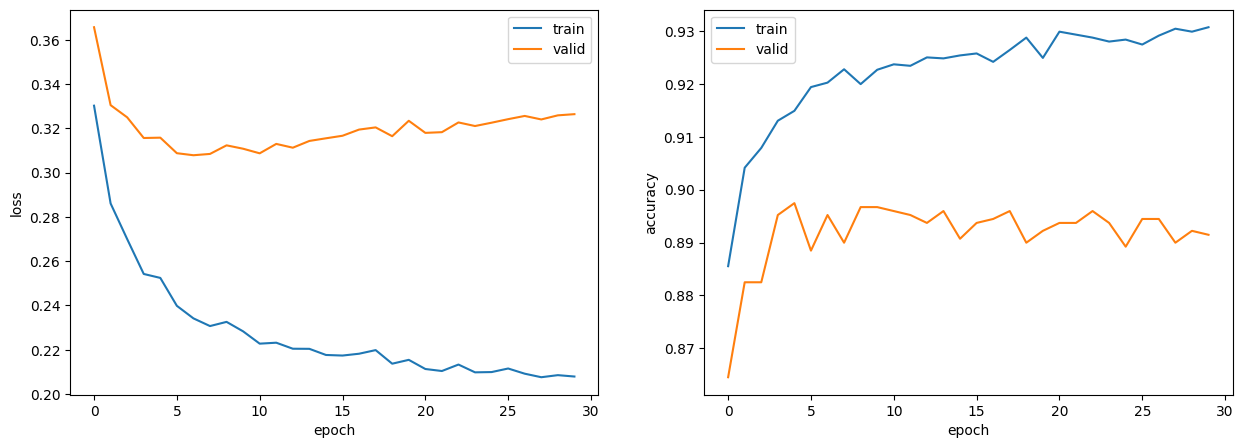

In [30]:
import numpy as np
from matplotlib import pyplot as plt

# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

## 76. チェックポイント
***
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [31]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')

epoch: 1, loss_train: 0.3322, accuracy_train: 0.8855, loss_valid: 0.3534, accuracy_valid: 0.8802
epoch: 2, loss_train: 0.2871, accuracy_train: 0.9046, loss_valid: 0.3223, accuracy_valid: 0.8952
epoch: 3, loss_train: 0.2696, accuracy_train: 0.9098, loss_valid: 0.3144, accuracy_valid: 0.8952
epoch: 4, loss_train: 0.2574, accuracy_train: 0.9154, loss_valid: 0.3093, accuracy_valid: 0.8945
epoch: 5, loss_train: 0.2441, accuracy_train: 0.9183, loss_valid: 0.3033, accuracy_valid: 0.8975
epoch: 6, loss_train: 0.2433, accuracy_train: 0.9182, loss_valid: 0.3087, accuracy_valid: 0.8960
epoch: 7, loss_train: 0.2344, accuracy_train: 0.9210, loss_valid: 0.3057, accuracy_valid: 0.8967
epoch: 8, loss_train: 0.2290, accuracy_train: 0.9250, loss_valid: 0.3023, accuracy_valid: 0.8975
epoch: 9, loss_train: 0.2266, accuracy_train: 0.9250, loss_valid: 0.3040, accuracy_valid: 0.8960
epoch: 10, loss_train: 0.2244, accuracy_train: 0.9250, loss_valid: 0.3047, accuracy_valid: 0.8960


## 77. ミニバッチ化
***
問題76のコードを改変し，$B$事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．$B$の値を$1,2,4,8,…$と変化させながら，1エポックの学習に要する時間を比較せよ．

In [32]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [33]:
# datasetの作成
dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3259, accuracy_train: 0.8899, loss_valid: 0.3507, accuracy_valid: 0.8802, 3.5735sec
バッチサイズ: 2
epoch: 1, loss_train: 0.2966, accuracy_train: 0.9022, loss_valid: 0.3298, accuracy_valid: 0.8877, 2.5780sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2893, accuracy_train: 0.9037, loss_valid: 0.3259, accuracy_valid: 0.8862, 1.3882sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2846, accuracy_train: 0.9059, loss_valid: 0.3224, accuracy_valid: 0.8900, 0.7659sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2829, accuracy_train: 0.9059, loss_valid: 0.3213, accuracy_valid: 0.8900, 0.4573sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2820, accuracy_train: 0.9059, loss_valid: 0.3205, accuracy_valid: 0.8900, 0.3042sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2816, accuracy_train: 0.9062, loss_valid: 0.3202, accuracy_valid: 0.8900, 0.2285sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2822, accuracy_train: 0.9062, loss_valid: 0.3201, accuracy_valid: 0.8900, 0.1858sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2816, accuracy_

## 78. GPU上での学習
***
問題77のコードを改変し，GPU上で学習を実行せよ．

In [35]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [36]:
# datasetの作成
dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3302, accuracy_train: 0.8882, loss_valid: 0.3550, accuracy_valid: 0.8870, 11.7108sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3004, accuracy_train: 0.8978, loss_valid: 0.3297, accuracy_valid: 0.8930, 4.8272sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2915, accuracy_train: 0.9008, loss_valid: 0.3251, accuracy_valid: 0.8945, 2.4951sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2872, accuracy_train: 0.9026, loss_valid: 0.3230, accuracy_valid: 0.8945, 1.3292sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2854, accuracy_train: 0.9036, loss_valid: 0.3213, accuracy_valid: 0.8922, 0.7178sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2845, accuracy_train: 0.9035, loss_valid: 0.3209, accuracy_valid: 0.8930, 0.4710sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2842, accuracy_train: 0.9034, loss_valid: 0.3208, accuracy_valid: 0.8915, 0.3405sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2833, accuracy_train: 0.9035, loss_valid: 0.3206, accuracy_valid: 0.8907, 0.1833sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2839, accuracy

## 79. 多層ニューラルネットワーク
***
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [37]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [38]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [39]:
# datasetの作成
dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 0.9514, accuracy_train: 0.7478, loss_valid: 0.9501, accuracy_valid: 0.7507, 0.5965sec
epoch: 2, loss_train: 0.7375, accuracy_train: 0.7668, loss_valid: 0.7334, accuracy_valid: 0.7747, 0.4847sec
epoch: 3, loss_train: 0.6607, accuracy_train: 0.7725, loss_valid: 0.6589, accuracy_valid: 0.7792, 0.4799sec
epoch: 4, loss_train: 0.6226, accuracy_train: 0.7770, loss_valid: 0.6235, accuracy_valid: 0.7844, 0.4860sec
epoch: 5, loss_train: 0.5924, accuracy_train: 0.7823, loss_valid: 0.5956, accuracy_valid: 0.7852, 0.4773sec
epoch: 6, loss_train: 0.5705, accuracy_train: 0.7863, loss_valid: 0.5758, accuracy_valid: 0.7882, 0.4644sec
epoch: 7, loss_train: 0.5474, accuracy_train: 0.7953, loss_valid: 0.5551, accuracy_valid: 0.7957, 0.4484sec
epoch: 8, loss_train: 0.5224, accuracy_train: 0.8084, loss_valid: 0.5315, accuracy_valid: 0.8039, 0.4929sec
epoch: 9, loss_train: 0.5019, accuracy_train: 0.8195, loss_valid: 0.5122, accuracy_valid: 0.8136, 0.4904sec
epoch: 10, loss_train: 0.480

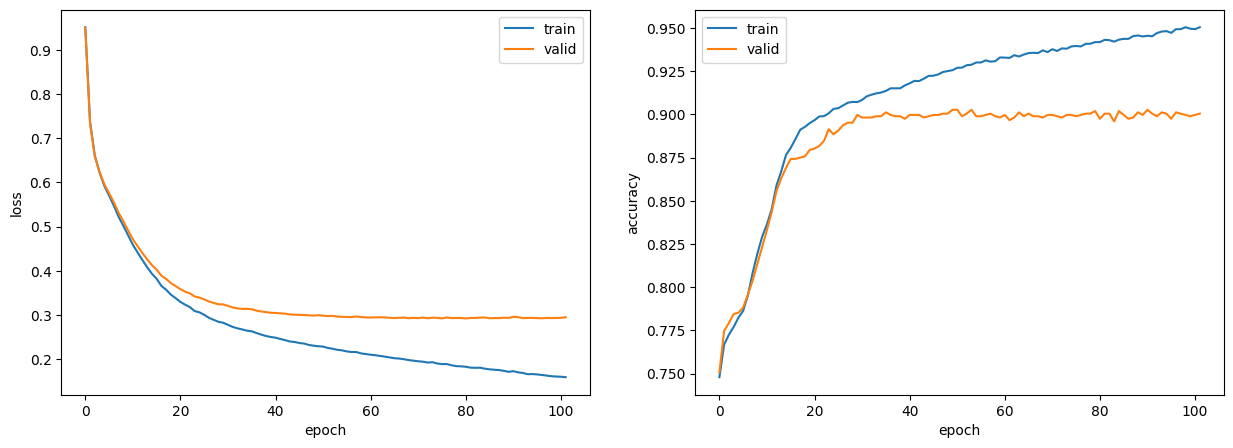

In [40]:
# 可視化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [41]:
def calculate_accuracy(model, X, y, device):
  model.eval()
  with torch.no_grad():
    inputs = X.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs, dim=-1).cpu()

  return (pred == y).sum().item() / len(y)

In [42]:
# 正解率の確認
acc_train = calculate_accuracy(model, X_train, y_train, device)
acc_test = calculate_accuracy(model, X_test, y_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.950
正解率（評価データ）：0.903
